In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## 데이터셋 불러오기

In [2]:
#https://github.com/tensorflow/datasets/issues/3918#issuecomment-1124730276
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:10000]', 'train[10000:12000]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

### 전처리
- 224x224 크기의 입력 이미지

In [4]:
def preprocess(image, label):
    IMAGE_SIZE = (224,224)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
BATCH_SIZE = 16

# train
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# test
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(buffer_size=tf.data.AUTOTUNE)

## 각 모델에 사용될 block 작성

- 참고 이미지  
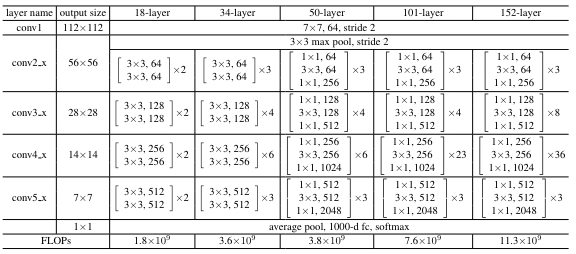

### plain34 block

In [6]:
def build_plain34_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer

    # cnn layers
    for num_cnn in range(num_cnns):
        # 블럭의 첫 cnn은 shape을 1/2로 줄임
        # shape 1/2 -> stride=2
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        # batch normalization, activation=relu
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 이하 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation2')(x)

    return x

### resnet34 block

In [7]:
def build_resnet34_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer
    
    # cnn layers
    for num_cnn in range(num_cnns):
        # 이전 출력값 저장
        x_prev = x
        
        # 블럭의 첫 cnn은 shape을 1/2로 줄임
        if num_cnn ==0 and block_num!=0:
            # shape 1/2 -> stride=2
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
            
            # 이전 출력값
            # 1x1 kernel, stride 2
            x_prev = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_short'
            )(x_prev)
            
            x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)
            

        else:
            # 크기 동일(stride=1)
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        # x와 f(x) Add
        x = keras.layers.Add(name=f'block{block_num}_{num_cnn}_Add')([x,x_prev])
        # 이후 relu
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

    return x

### plain50 block

In [8]:
def build_plain50_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer

    # cnn layers
    for num_cnn in range(num_cnns):
        # 1번 layer
        # 블럭의 첫 cnn은 shape을 1/2로 줄임 -> strides=2
        # kernel 1x1, filter 동일
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
        
        # 크기 동일(stride=1)
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
        # batch normalization, activation=relu
        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 2번 layer
        # kernel 3x3, filter 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

        # 3번 layer
        # kernel 1x1, filter 4배
        x = keras.layers.Conv2D(
            filters = channel*4,
            kernel_size=(1,1),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv3'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN3')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation3')(x)

    return x

### resnet50 block

In [9]:
def build_resnet50_block(
    input_layer,
    channel, 
    num_cnns,
    block_num
):
    # input layer
    x = input_layer
    
    # cnn layers
    for num_cnn in range(num_cnns):
        # 이전 출력값 저장
        x_prev = x
        
        # 1번 layer
        # 블럭의 첫 cnn은 shape을 1/2로 줄임 -> strides=2
        # kernel 1x1, filter 동일
        if num_cnn ==0 and block_num!=0:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)
            
            # 이전 출력값
            # 1x1 kernel, stride 2
            x_prev = keras.layers.Conv2D(
                filters = channel*4,
                kernel_size=(1,1),
                strides=2,
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_short'
            )(x_prev)
            
            x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)

        else:
            # 크기 동일(stride=1)
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                activation=None,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_{num_cnn}_conv1'
            )(x)

            # 첫 블럭 부분
            if num_cnn ==0 and block_num==0:
                x_prev = keras.layers.Conv2D(
                    filters = channel*4,
                    kernel_size=(1,1),
                    activation=None,
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_{num_cnn}_short'
                )(x_prev)
                x_prev = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BNShort')(x_prev)


        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN1')(x)
        x = keras.layers.Activation(activation='relu', name=f'block{block_num}_{num_cnn}_Activation1')(x)

        # 2번 layer
        # kernel 3x3, filter 동일
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv2'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN2')(x)
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation2')(x)

        # 3번 layer
        # kernel 1x1, filter 4배
        x = keras.layers.Conv2D(
            filters = channel*4,
            kernel_size=(1,1),
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_{num_cnn}_conv3'
        )(x)

        x = keras.layers.BatchNormalization(name=f'block{block_num}_{num_cnn}_BN3')(x)
        
        # x와 f(x) Add
        x = keras.layers.Add(name=f'block{block_num}_{num_cnn}_Add')([x,x_prev])
        # 이후 relu
        x = keras.layers.Activation(activation='relu',name=f'block{block_num}_{num_cnn}_Activation3')(x)

    return x

### resnet 통합 모델 method

In [10]:
def build_resnet(
    input_shape=(224,224,3),
    num_classes=10,
    is_50=False,
    is_Plain=False
):
    # layers, filters
    num_cnn_list=[3,4,6,3]
    channel_list=[64,128,256,512]

    # input
    input_layer = keras.Input(shape=input_shape)

    # 이미지 참고
    # conv1_x -> kernel 7x7, filter 64, stride 2
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        padding='same',
        name='block0_0_conv'
    )(input_layer)

    output = keras.layers.BatchNormalization(name='block0_0_BN')(output)
    output = keras.layers.Activation(activation='relu', name='block0_0_Activation')(output)
    
    # 이미지 참고
    # conv2_x -> maxpool 3x3, stride 2
    output = keras.layers.MaxPooling2D(
        pool_size=(3,3),
        strides=2,
        padding='same',
        name='block0_0_MaxPooling'
    )(output)

    # 각 block에 들어갈 layer 및 filter 수
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # Plain 모델인 경우,
        if is_Plain:
            if is_50:
                output = build_plain50_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
            else:
                output = build_plain34_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
        # Resnet 모델인 경우,
        else:
            if is_50:
                output = build_resnet50_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
            else:
                output = build_resnet34_block(input_layer=output,num_cnns=num_cnn, channel=channel,block_num=i)
    
    # 이미지 참고
    # output size 1x1
    output = keras.layers.AveragePooling2D(pool_size=output.shape[-2],padding='same',name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    if num_classes == 1:
        output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000d')(output)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000d')(output)  

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )

    return model

## Model summary

In [11]:
model_plain34 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, is_Plain=True)
model_plain50 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=True, is_Plain=True)
model_resnet34 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=False, is_Plain=False)
model_resnet50 = build_resnet(input_shape=(224,224,3), num_classes=1, is_50=True, is_Plain=False)

In [12]:
model_resnet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block0_0_conv (Conv2D)          (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
block0_0_BN (BatchNormalization (None, 112, 112, 64) 256         block0_0_conv[0][0]              
__________________________________________________________________________________________________
block0_0_Activation (Activation (None, 112, 112, 64) 0           block0_0_BN[0][0]                
____________________________________________________________________________________________

In [13]:
model_plain50.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_0_conv (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
block0_0_BN (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
block0_0_Activation (Activat (None, 112, 112, 64)      0         
_________________________________________________________________
block0_0_MaxPooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
block0_0_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
block0_0_BN1 (BatchNormaliza (None, 56, 56, 64)        256 

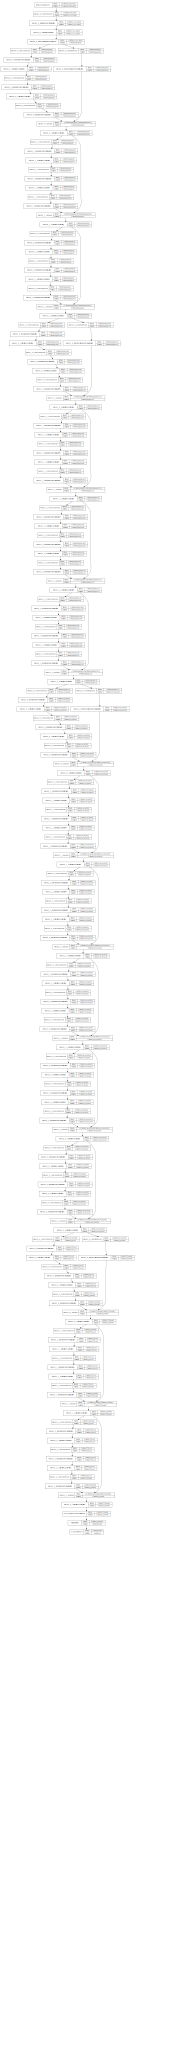

In [14]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Jupyter Notebook에 모델 시각화
SVG(model_to_dot(model_resnet50, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## 각 모델에 대해 학습

In [15]:
EPOCHS = 60

### resnet50

In [16]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_resnet50 = model_resnet50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)

Epoch 1/60
308/625 [=============>................] - ETA: 54s - loss: 0.7769 - accuracy: 0.5767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


489/625 [======================>.......] - ETA: 23s - loss: 0.7400 - accuracy: 0.5838

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


516/625 [=======================>......] - ETA: 19s - loss: 0.7389 - accuracy: 0.5850

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


522/625 [========================>.....] - ETA: 18s - loss: 0.7371 - accuracy: 0.5862

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.5931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


625/625 [==============================] - 132s 194ms/step - loss: 0.7223 - accuracy: 0.5931 - val_loss: 0.6761 - val_accuracy: 0.5850
Epoch 2/60
625/625 [==============================] - 117s 187ms/step - loss: 0.6377 - accuracy: 0.6483 - val_loss: 1.9134 - val_accuracy: 0.5795
Epoch 3/60
625/625 [==============================] - 116s 186ms/step - loss: 0.5873 - accuracy: 0.6889 - val_loss: 0.7646 - val_accuracy: 0.5385
Epoch 4/60
625/625 [==============================] - 117s 187ms/step - loss: 0.5746 - accuracy: 0.7049 - val_loss: 0.6594 - val_accuracy: 0.6265
Epoch 5/60
625/625 [==============================] - 116s 186ms/step - loss: 0.5339 - accuracy: 0.7368 - val_loss: 0.8572 - val_accuracy: 0.6090
Epoch 6/60
625/625 [==============================] - 116s 186ms/step - loss: 0.4884 - accuracy: 0.7648 - val_loss: 1.6699 - val_accuracy: 0.5580
Epoch 7/60
625/625 [==============================] - 117s 186ms/step - loss: 0.4603 - accuracy: 0.7870 - val_loss: 1.1172 - val_accura

### plain50

In [17]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_plain50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_plain50 = model_plain50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)

Epoch 1/60
625/625 [==============================] - 102s 156ms/step - loss: 0.7086 - accuracy: 0.5082 - val_loss: 0.7040 - val_accuracy: 0.5260
Epoch 2/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6987 - accuracy: 0.5052 - val_loss: 0.6952 - val_accuracy: 0.5045
Epoch 3/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6971 - accuracy: 0.5033 - val_loss: 0.7069 - val_accuracy: 0.5350
Epoch 4/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6999 - accuracy: 0.5045 - val_loss: 1.2082 - val_accuracy: 0.5075
Epoch 5/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6964 - accuracy: 0.5132 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 6/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6985 - accuracy: 0.5128 - val_loss: 0.6928 - val_accuracy: 0.5145
Epoch 7/60
625/625 [==============================] - 97s 155ms/step - loss: 0.6987 - accuracy: 0.5046 - val_loss: 0.9275 - val_a

### resnet34

In [18]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_resnet34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_resnet34 = model_resnet34.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)

Epoch 1/60
625/625 [==============================] - 73s 112ms/step - loss: 0.7465 - accuracy: 0.5584 - val_loss: 0.8187 - val_accuracy: 0.5455
Epoch 2/60
625/625 [==============================] - 69s 110ms/step - loss: 0.6714 - accuracy: 0.5949 - val_loss: 0.6660 - val_accuracy: 0.5995
Epoch 3/60
625/625 [==============================] - 69s 111ms/step - loss: 0.6568 - accuracy: 0.6154 - val_loss: 0.6360 - val_accuracy: 0.6355
Epoch 4/60
625/625 [==============================] - 69s 111ms/step - loss: 0.6358 - accuracy: 0.6412 - val_loss: 0.6547 - val_accuracy: 0.6045
Epoch 5/60
625/625 [==============================] - 69s 111ms/step - loss: 0.5983 - accuracy: 0.6814 - val_loss: 0.6253 - val_accuracy: 0.6550
Epoch 6/60
625/625 [==============================] - 69s 110ms/step - loss: 0.5586 - accuracy: 0.7163 - val_loss: 0.6114 - val_accuracy: 0.6735
Epoch 7/60
625/625 [==============================] - 69s 110ms/step - loss: 0.5219 - accuracy: 0.7368 - val_loss: 1.9176 - val_ac

### plain34

In [19]:
# 모델 컴파일
# num_classes=1로 설정(sigmoid)했으므로 binary_crossentropy로 설정
# 평가지표는 단순 accuracy로 설정
model_plain34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
history_plain34 = model_plain34.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)

Epoch 1/60
625/625 [==============================] - 70s 107ms/step - loss: 0.7088 - accuracy: 0.5170 - val_loss: 0.7298 - val_accuracy: 0.5125
Epoch 2/60
625/625 [==============================] - 66s 106ms/step - loss: 0.6923 - accuracy: 0.5306 - val_loss: 0.7336 - val_accuracy: 0.5210
Epoch 3/60
625/625 [==============================] - 66s 106ms/step - loss: 0.6955 - accuracy: 0.5190 - val_loss: 0.7817 - val_accuracy: 0.4970
Epoch 4/60
625/625 [==============================] - 66s 106ms/step - loss: 0.6881 - accuracy: 0.5239 - val_loss: 0.7072 - val_accuracy: 0.4875
Epoch 5/60
625/625 [==============================] - 66s 105ms/step - loss: 0.6739 - accuracy: 0.5759 - val_loss: 0.6711 - val_accuracy: 0.6075
Epoch 6/60
625/625 [==============================] - 66s 106ms/step - loss: 0.6660 - accuracy: 0.5964 - val_loss: 1.9484 - val_accuracy: 0.5340
Epoch 7/60
625/625 [==============================] - 66s 106ms/step - loss: 0.6565 - accuracy: 0.6147 - val_loss: 0.6685 - val_ac

## History 비교

In [20]:
import matplotlib.pyplot as plt

In [21]:
model_plain34.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_0_conv (Conv2D)       (None, 112, 112, 64)      9472      
_________________________________________________________________
block0_0_BN (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
block0_0_Activation (Activat (None, 112, 112, 64)      0         
_________________________________________________________________
block0_0_MaxPooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
block0_0_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
block0_0_BN1 (BatchNormaliza (None, 56, 56, 64)        256   

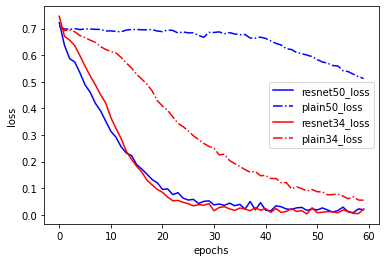

In [22]:
plt.plot(history_resnet50.history['loss'], 'b', label='resnet50_loss')
plt.plot(history_plain50.history['loss'], 'b-.', label='plain50_loss')
plt.plot(history_resnet34.history['loss'], 'r', label='resnet34_loss')
plt.plot(history_plain34.history['loss'], 'r-.', label='plain34_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

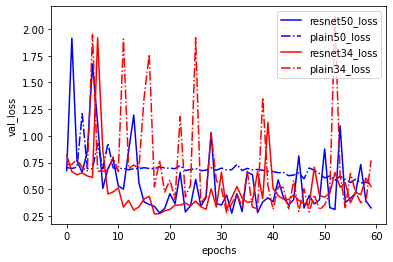

In [23]:
plt.plot(history_resnet50.history['val_loss'], 'b', label='resnet50_loss')
plt.plot(history_plain50.history['val_loss'], 'b-.', label='plain50_loss')
plt.plot(history_resnet34.history['val_loss'], 'r', label='resnet34_loss')
plt.plot(history_plain34.history['val_loss'], 'r-.', label='plain34_loss')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.legend()
plt.show()

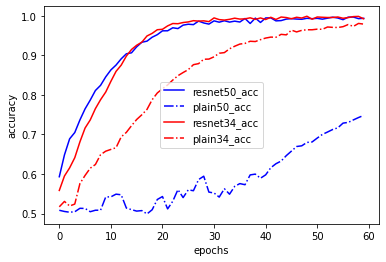

In [24]:
plt.plot(history_resnet50.history['accuracy'], 'b', label='resnet50_acc')
plt.plot(history_plain50.history['accuracy'], 'b-.', label='plain50_acc')
plt.plot(history_resnet34.history['accuracy'], 'r', label='resnet34_acc')
plt.plot(history_plain34.history['accuracy'], 'r-.', label='plain34_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

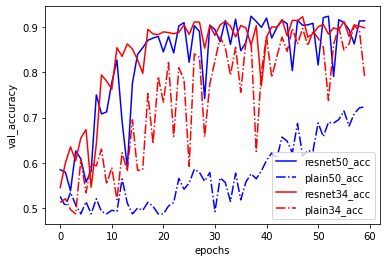

In [25]:
plt.plot(history_resnet50.history['val_accuracy'], 'b', label='resnet50_acc')
plt.plot(history_plain50.history['val_accuracy'], 'b-.', label='plain50_acc')
plt.plot(history_resnet34.history['val_accuracy'], 'r', label='resnet34_acc')
plt.plot(history_plain34.history['val_accuracy'], 'r-.', label='plain34_acc')
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.legend()
plt.show()

## 회고

### Plain vs ResNet
- 어떤 지표에서는 Resnet 모델이 Plain 모델보다 더 빠르게 학습 진행
- 특히 Plain50은 그 중에서도 가장 학습의 진척이 엄청 느림
- val_accuracy도 성능이 떨어지지 않고 오르는 것을 보면 아직 오버피팅은 오지 않은듯

### 느낀점
- 논문만 보고 모델을 구현하는 것은 굉장히 어렵다는 것을 알게됨
- epoch을 60까지 하니까 학습하는데 시간이 굉장히 오래 걸림
- 잔차연결에서의 성능 향상이 눈에 띄게 좋음을 알 수 있음